# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

import os, sys, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap

import seaborn as sn

import anndata
import scanpy as sc
import sctk as sk


rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sk.set_figsize((4, 4))
expr_cmap = sk.expression_colormap()

# Load data

In [2]:
fetal_ad = sc.read("../20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [3]:
fetal_ad.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435, 2.8572528], dtype=float32)

In [4]:
fetal_ad.obs.joint_annotation_20220202.cat.categories.tolist()

['ASDC',
 'Iron-recycling macrophage',
 'Adipocytes',
 'Arterial',
 'B cell',
 'Basal',
 'POSTN+ basal',
 'CD4 T cell',
 'CD8 T cell',
 'Capillary (venular tip)',
 'Capillary/postcapillary venule',
 'Companion layer',
 'Cuticle/cortex',
 'DC1',
 'DC2',
 'Dermal condensate',
 'Dermal papillia',
 'Early LE',
 'Early endothelial cell',
 'Early erythroid',
 'Early erythroid (embryonic)',
 'FRZB+ early fibroblast',
 'HOXC5+ early fibroblast',
 'Early myocytes',
 'Eo/baso/mast cell progenitor',
 'Erythroid (embryonic)',
 'Erythroid (fetal)',
 'PEAR1+ fibroblast',
 'WNT2+ fibroblast',
 'HSC',
 'ILC2',
 'ILC3',
 'Immature basal',
 'Immature suprabasal',
 'Inflammatory DC',
 'Innate T type1',
 'Innate T type3',
 'Inner root sheath',
 'LC',
 'LE',
 'LTi',
 'Lymphoid progenitor',
 'MEMP - Early erythroid',
 'MEMP - Megak',
 'MHCII+ macrophage',
 'LYVE1++ macrophage',
 'Mast cell (earliest)',
 'Mast cell (medium)',
 'Mast cell (most mature)',
 'Matrix/placode',
 'Megakaryocyte',
 'Melanoblast',
 '

# Process

## Subset, prepare variables

In [5]:
nonHF_KCs = [
    "Periderm",
    "Immature basal",
    "Immature suprabasal",
    "POSTN+ basal",
    "Basal",
    "Suprabasal IFE",
]

In [95]:
stages = ["7-8", "9-11", "12-16"]

In [6]:
genes = [
    "HES1",
    "SPP1",
    "SLC2A3",
    "SVIL",
    "KRT18",
    "ITM2C",
    "PCP4",
    "ELF3",
    "EGLN3",
    "CLDN4",
    "KRT13",
    "RTN1",
    "LUM",
    "C2orf40",
    "BST1",
    "SFRP2",
    "PHACTR3",
    "KRTDAP",
    "MAL2",
    "TTR",
    "ABI3BP",
    "GABARAP",
    "TM4SF1",
    "WIF1",
    "COL14A1",
    "EMP2",
    "KRT14",
    "PTCH2",
    "PCBP2",
    "ATP6V0C",
]

In [7]:
k_nonHF_KC = fetal_ad.obs.joint_annotation_20220202.isin(nonHF_KCs)

In [8]:
ad1 = fetal_ad[k_nonHF_KC]

In [9]:
ad1.obs["joint_annotation_20220202"] = ad1.obs.joint_annotation_20220202.cat.reorder_categories(
    nonHF_KCs
)

Trying to set attribute `.obs` of view, copying.


In [11]:
sorted(list(fetal_ad.obs.pcw.unique()))

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [10]:
sorted(list(ad1.obs.pcw.unique()))

[7, 8, 9, 11, 14, 15, 16]

In [12]:
ad1.obs["pcw_text"] = ad1.obs.pcw.astype(str)

ad1.obs["stage"] = sk.regroup(
    ad1,
    groupby="pcw_text",
    regroups={
        "7-8": ["7", "8"],
        "9-11": ["9", "11"],
        "12-16": ["14", "15", "16"],
    },
)

## Extract and prepare data to plot

In [22]:
X = (
    pd.concat(
        [pd.Series(ad1.obs_vector(g), index=ad1.obs_names) for g in genes],
        axis=1,
    )
    .rename(columns={i: g for i, g in enumerate(genes)})
    .assign(annot=ad1.obs.joint_annotation_20220202, stage=ad1.obs.stage)
)

In [87]:
ct_df = (
    X.melt(id_vars=["annot", "stage"], var_name="gene", value_name="expression")
    .groupby(["annot", "gene"])
    .agg(
        mean=pd.NamedAgg(column="expression", aggfunc="mean"),
        frac=pd.NamedAgg(column="expression", aggfunc=lambda x: (x > 0).mean()),
    )
    .reset_index()
)
ct_df["gene"] = ct_df["gene"].astype(pd.CategoricalDtype(categories=genes, ordered=True))
ct_df["x"] = ct_df.gene.cat.codes
ct_df["annot"] = ct_df["annot"].astype(
    pd.CategoricalDtype(categories=nonHF_KCs[::-1], ordered=True)
)
ct_df["y"] = ct_df.annot.cat.codes
ct_df = ct_df.merge(
    ct_df.groupby("gene")["mean"].max().rename("max_mean"),
    how="left",
    left_on="gene",
    right_index=True,
)
ct_df["mean2"] = ct_df["mean"] / ct_df["max_mean"]

In [88]:
st_df = (
    X.melt(id_vars=["annot", "stage"], var_name="gene", value_name="expression")
    .groupby(["stage", "gene"])
    .agg(
        mean=pd.NamedAgg(column="expression", aggfunc="mean"),
        frac=pd.NamedAgg(column="expression", aggfunc=lambda x: (x > 0).mean()),
    )
    .reset_index()
)
st_df["gene"] = st_df["gene"].astype(pd.CategoricalDtype(categories=genes, ordered=True))
st_df["x"] = st_df.gene.cat.codes
st_df["stage"] = st_df["stage"].astype(pd.CategoricalDtype(categories=stages[::-1], ordered=True))
st_df["y"] = st_df.stage.cat.codes
st_df = st_df.merge(
    st_df.groupby("gene")["mean"].max().rename("max_mean"),
    how="left",
    left_on="gene",
    right_index=True,
)
st_df["mean2"] = st_df["mean"] / st_df["max_mean"]

In [89]:
df = pd.concat(
    [
        st_df.melt(id_vars=["gene", "mean", "max_mean", "mean2", "frac", "x", "y"]),
        ct_df.melt(id_vars=["gene", "mean", "max_mean", "mean2", "frac", "x", "y"]),
    ]
)

## Plot

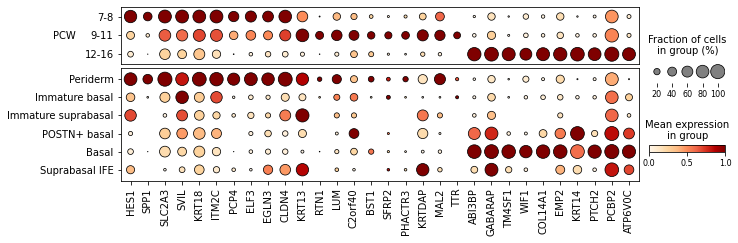

In [180]:
# Main axes
g = sn.relplot(
    data=df,
    x="x",
    y="y",
    hue="mean2",
    size="frac",
    sizes=(0, 200),
    edgecolor="k",
    row="variable",
    facet_kws={
        "sharex": False,
        "sharey": False,
        "gridspec_kws": dict(hspace=0.05, height_ratios=[0.333, 0.667]),
    },
    legend=False,
    height=1.6,
    aspect=6,
    palette="OrRd",
)
g.set_titles("")
sn.despine(fig=g.fig, right=False, top=False)

g.axes[0, 0].margins(0.02, 0.25)
g.axes[0, 0].set_xticks([])
g.axes[0, 0].set_yticks(np.arange(len(stages)))
g.axes[0, 0].set_yticklabels(stages[::-1])
g.axes[0, 0].set_ylabel("PCW", labelpad=20, rotation=0, va="center_baseline")

g.axes[1, 0].margins(0.02, 0.125)
g.axes[1, 0].set_xticks(np.arange(len(genes)))
g.axes[1, 0].set_xticklabels(genes, rotation=90)
g.axes[1, 0].set_xlabel("")
g.axes[1, 0].set_yticks(np.arange(len(nonHF_KCs)))
g.axes[1, 0].set_yticklabels(nonHF_KCs[::-1])
g.axes[1, 0].set_ylabel("")

# Make legend
fig = g.fig
main_width = 0.875
gap_width = 0.015
fig.subplots_adjust(right=main_width)

# Dot size legend
dlg_ax = fig.add_axes([main_width + gap_width, 0.55, 1 - main_width - gap_width, 0.1])
sn.scatterplot(
    x=[20, 40, 60, 80, 100],
    y=[0, 0, 0, 0, 0],
    size=[20, 40, 60, 80, 100],
    sizes=(40, 200),
    color=[(0.5, 0.5, 0.5)],
    edgecolor="black",
    ax=dlg_ax,
    legend=False,
)
sn.despine(ax=dlg_ax, left=True, bottom=True)
dlg_ax.get_yaxis().set_visible(False)
dlg_ax.set_xticks([20, 40, 60, 80, 100])
dlg_ax.set_xticklabels([20, 40, 60, 80, 100], size=8)
dlg_ax.set_xlim(10, 110)
dlg_ax.set_title("Fraction of cells\nin group (%)", size=10)

# Colorbar
cb_ax = fig.add_axes([main_width + gap_width, 0.25, 1 - main_width - gap_width, 0.03])
fig.colorbar(
    plt.cm.ScalarMappable(
        cmap="OrRd",
    ),
    cax=cb_ax,
    orientation="horizontal",
)
sn.despine(ax=cb_ax, left=True, bottom=True)
cb_ax.get_yaxis().set_visible(False)
cb_ax.set_xticks([0, 0.5, 1])
cb_ax.set_xticklabels([0.0, 0.5, 1.0], size=8)
cb_ax.set_title("Mean expression\nin group", size=10);

In [181]:
fig.savefig("figures/fig2C.20220906.pdf", bbox_inches="tight")

In [182]:
!rclone copy --drive-shared-with-me figures/fig2C.20220906.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"